# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

1. [Introduction](#intro)<br>
2. [Load & clean dataset](#wrangling)<br>
3. [Exploratory data analysis](#eda)<br>
4. [Feature engineering](#feateng)<br>
5. [Modeling](#model)<br>
6. [Conclusion](#results)<br>


# <a class="anchor" id="intro">1. Introduction</a>

Along this project, we will be working on a challenging real case problem that many customer-facing business have to deal with, which is how to predict the churn rate of their users.

To accomplish the project, we have been provided with a datastet from Sparkify organization.

We will be working on large dataset hence usage of Spark will be key to manipulate the data. Spark ML lib will also be deterministic in the best choice of algorithm to pick and evaluate for our predictive model.


In [2]:
# import libraries
import datetime
import time
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession


from pyspark.sql.functions import col,isnan, when, count,lower,udf, datediff,countDistinct
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType



from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'pyspark'

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("SparkifyProject") \
    .getOrCreate()

# <a class="anchor" id="wrangling">2. Load & clean dataset</a>
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# load dataset
df = spark.read.json("mini_sparkify_event_data.json")

In [4]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [5]:
# check for schema data types
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# shape of dataset
print((df.count(), len(df.columns)))

(286500, 18)


In [7]:
# check for empty/null values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



`.` We have some nan/null values that we'll have to take care of before building our model.
Those empty values can not be dropped arbitrarily in our case since they might be expected for some of the events logged in data.

In [8]:
# checking for duplicates rows cross all cols
df.exceptAll(df.dropDuplicates(df.columns)).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [9]:
# check num of rows after removing dups 
print((df.count(), len(df.columns)))

(286500, 18)


`.` no duplicate row found checking for all cols in dataset

In [10]:
# lower case all col names
df_clean = df.select([F.col(x).alias(x.lower()) for x in df.columns])

In [11]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- iteminsession: long (nullable = true)
 |-- lastname: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionid: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- useragent: string (nullable = true)
 |-- userid: string (nullable = true)



In [12]:
# removing userID set as empty string
df_clean = df_clean.filter(df_clean["userid"] != "")


`.` We had some rows storing userid as empty string. This would break some operations carried out later and such records do not bring
any value, therefore we can safely remove those.

In [13]:
# Define udf to convert epoch timestamp to human readable date format
convert_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [14]:
# create new col event_timedate
df_clean = df_clean.withColumn("event_timedate", convert_datetime(df_clean.ts))

# create new col registration_date
df_clean = df_clean.withColumn("registration_timedate", convert_datetime(df_clean.registration))

In [15]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- iteminsession: long (nullable = true)
 |-- lastname: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionid: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- useragent: string (nullable = true)
 |-- userid: string (nullable = true)
 |-- event_timedate: string (nullable = true)
 |-- registration_timedate: string (nullable = true)



`.` new columns created properly showing up in schema

In [16]:
# cast data type to sort our data
df_clean = df_clean.withColumn("userid",df_clean.userid.cast(IntegerType()))
df_clean = df_clean.withColumn("ts",df_clean.ts.cast(IntegerType()))


In [17]:
# sort events by user and time
df_clean = df_clean.sort(['userid','ts'], ascending=True)

# check is events are sorted properly
df_clean.filter(df_clean["userid"] == 30).toPandas().head()

,artist,auth,firstname,gender,iteminsession,lastname,length,level,location,method,page,registration,sessionid,song,status,ts,useragent,userid,event_timedate,registration_timedate
0,None,Logged In,Colin,M,2,Freeman,NaN,free,"Bakersfield, CA",GET,Home,1538173362000,945,None,200,-1822290264,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-20 21:29:29,2018-09-28 22:22:42
1,Carbon Based Lifeforms,Logged In,Colin,M,0,Freeman,425.27302,free,"Bakersfield, CA",PUT,NextSong,1538173362000,1110,Silent Running,200,-1625175264,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-23 04:14:44,2018-09-28 22:22:42
2,Metallica,Logged In,Colin,M,1,Freeman,396.40771,free,"Bakersfield, CA",PUT,NextSong,1538173362000,1110,The Unforgiven II,200,-1624750264,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-23 04:21:49,2018-09-28 22:22:42
3,Les MisÃÂ©rables - 10th Anniversary Concert,Logged In,Colin,M,2,Freeman,219.92444,free,"Bakersfield, CA",PUT,NextSong,1538173362000,1110,Valjean's Soliloquy,200,-1624354264,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-23 04:28:25,2018-09-28 22:22:42
4,FM Static,Logged In,Colin,M,3,Freeman,218.27873,free,"Bakersfield, CA",PUT,NextSong,1538173362000,1110,Tonight,200,-1624135264,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-23 04:32:04,2018-09-28 22:22:42


`.` We are sorting all users interactions in chronological order (asc). let's see if we can later extract some feature out of it. Having the ordered sequences of actions performed might help us to identify possible pain points churn users came across.

# <a class="anchor" id="eda">3. Exploratory data analysis</a>



When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [18]:
# identify churned users
churn_ids = df_clean.select("userid").where(df_clean.page =="Cancellation Confirmation")

churn_ids_list = churn_ids.select("userid").rdd.flatMap(lambda x: x).collect()

In [19]:
# add new col to identify actions made by churned/not churned users
df_clean = df_clean.withColumn("has_cancelled",when((df_clean.userid.isin(churn_ids_list)), 1).otherwise(0))

In [20]:
# check for num of churned users
df_clean.groupBy("has_cancelled").agg(countDistinct('userid')).show()

+-------------+----------------------+
|has_cancelled|count(DISTINCT userid)|
+-------------+----------------------+
|            1|                    52|
|            0|                   173|
+-------------+----------------------+



`.` all rows/interactions made to churned users will return `has_cancelled ==1`

`.` we only have 52 users who churned, even thought they count for 30% of our users base, this number might be too small, let's also consider to add users who downgraded.

In [21]:
# identify users who downgraded
downgrade_ids = df_clean.select("userid").where(df_clean.page =="Downgrade")

downgrade_ids_list = downgrade_ids.select("userid").rdd.flatMap(lambda x: x).collect()

In [22]:
# add downgraded users col to dataset

df_clean = df_clean.withColumn("has_downgraded",when((df_clean.userid.isin(downgrade_ids_list)), 1).otherwise(0))

In [23]:
# check for num of downgraded users
df_clean.groupBy("has_downgraded").agg(countDistinct('userid')).show()

+--------------+----------------------+
|has_downgraded|count(DISTINCT userid)|
+--------------+----------------------+
|             1|                   154|
|             0|                    71|
+--------------+----------------------+



`.` all rows/interactions made to users who downgraded will return `has_downgraded ==1`

`.` it will be interesting to look at if users who churned did downgrade before. It might be a sign user is about to leave.


In [24]:
# Descriptive statistics for numerical variables
df_clean.select([col[0] for col in df_clean.dtypes if col[1] != 'string']).toPandas().describe()

,iteminsession,length,registration,sessionid,status,ts,userid,has_cancelled,has_downgraded
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05,278154.000000,278154.000000,278154.000000
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,2.021887e+08,59682.022786,0.161292,0.937308
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.252569e+09,109091.949999,0.367801,0.242408
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,-2.147464e+09,2.000000,0.000000,0.000000
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,-8.892365e+08,51.000000,0.000000,1.000000
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,4.292007e+08,98.000000,0.000000,1.000000
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.329670e+09,100004.000000,0.000000,1.000000
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,2.147455e+09,300025.000000,1.000000,1.000000


`.` we don't have too many insightful numerical variables.

`.` `iteminsession` since its attached to sessionid, counter probably resets for every new session (i.e cold-start problem?)

`.` `length` being the time (secs) a song was played.

`.` other vars are not being of interest for our model, we will have to make sure to do some feature engineering work

In [25]:
# create view 'sparkify_users_interactions_churn' to use sql

df_clean.createOrReplaceTempView("sparkify_users_interactions_churn")

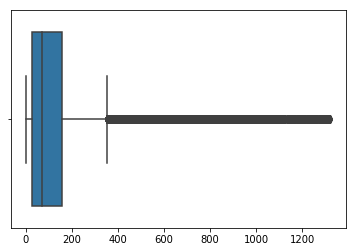

In [26]:
# viz iteminsession
q1 = spark.sql('''
        SELECT iteminsession
        FROM sparkify_users_interactions_churn
        ''').toPandas()


sns.boxplot(q1);

`.` As expected from summary statistics displayed above, distribution of our variable is positively skewed to the right with an average 
of 115 iteminsession but still many users located under value reported as first quartile (27).

`.` There are also 


In [27]:
# create new column registering diff in days since user signed up
df_clean = df_clean.withColumn("num_days_since_signup", datediff(col("event_timedate"),col("registration_timedate")))


In [28]:
# update table with new col
df_clean.createOrReplaceTempView("sparkify_users_interactions_churn")

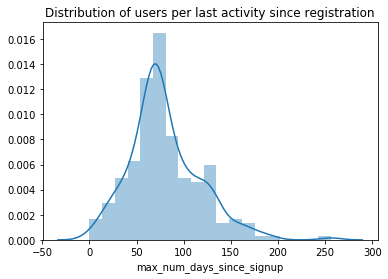

In [29]:
q2 = spark.sql('''
        SELECT DISTINCT userid, MAX(num_days_since_signup) as max_num_days_since_signup
        FROM sparkify_users_interactions_churn
        GROUP BY userid
        
        ''').toPandas()

sns.distplot(q2.max_num_days_since_signup);

plt.title('Distribution of users per last activity since registration')
plt.show()

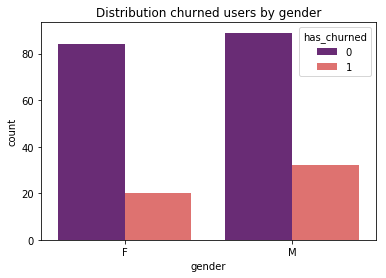

In [30]:

q3 = spark.sql('''
        SELECT gender,has_cancelled as has_churned, userid
        FROM sparkify_users_interactions_churn
    
    group by 1,2,3
''').toPandas()


sns.countplot(x = 'gender', hue = 'has_churned', data = q3, palette = 'magma')
plt.title('Distribution churned users by gender')
plt.show()

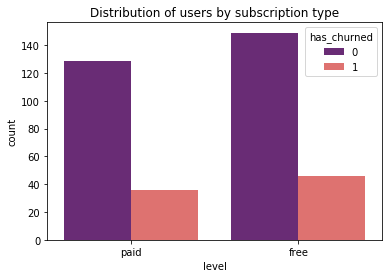

In [31]:
q4 = spark.sql('''
        SELECT level,has_cancelled as has_churned, userid
        FROM sparkify_users_interactions_churn
    group by 1,2,3
''').toPandas()

#sns.distplot(q1.has_churned);

sns.countplot(x = 'level', hue = 'has_churned', data = q4, palette = 'magma')
plt.title('Distribution of users by subscription type')
plt.show()

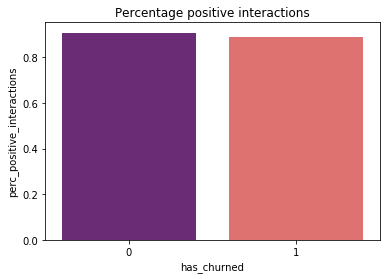

In [32]:
# Percentage of positive & negative interactions for churn
q5 = spark.sql('''
        SELECT has_cancelled as has_churned
                ,(count(case when page in ('Add Friend','Add to Playlist','NextSong','Thumbs Up') then 1 else null end)/ count(*)) as perc_positive_interactions

        FROM sparkify_users_interactions_churn
        --where has_cancelled = 1
     group by 1

''').toPandas()


sns.barplot(x = 'has_churned',y='perc_positive_interactions', data = q5, palette = 'magma')
plt.title('Percentage positive interactions')
plt.show()




`.` Not a real significant difference between the two groups of events.We should probably dig deeper and look at each one of them individually

# <a class="anchor" id="feateng">4. Features engineering</a>


Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [33]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- iteminsession: long (nullable = true)
 |-- lastname: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionid: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: integer (nullable = true)
 |-- useragent: string (nullable = true)
 |-- userid: integer (nullable = true)
 |-- event_timedate: string (nullable = true)
 |-- registration_timedate: string (nullable = true)
 |-- has_cancelled: integer (nullable = false)
 |-- has_downgraded: integer (nullable = false)
 |-- num_days_since_signup: integer (nullable = true)



artist -> to see.

auth -> keep -> transformed-> done
#firstname -> remove
gender -> keep -> transformed -> done
iteminsession -> see what is it first
#lastname -> remove
length -> to remove ?
level -> as cateforical -> done
#location -> to remove
#method -> to remove
last event -> to create. before cancellation
song -> to see
#user agant -> remove
first event -> to create
vector with all events?



In [34]:
# add meaningful events 

positive_experience = ['Add Friend','Add to Playlist','NextSong','Thumbs Up']
negative_experience = ['Error','Submit Downgrade','Thumbs Down','Help']

In [35]:
# 
SI_gender = StringIndexer(inputCol='gender',outputCol='gender_index')
SI_level = StringIndexer(inputCol='level',outputCol='level_index')
SI_auth = StringIndexer(inputCol='auth',outputCol='auth_index')

In [36]:
df_clean = SI_gender.fit(df_clean).transform(df_clean)
df_clean = SI_level.fit(df_clean).transform(df_clean)
df_clean = SI_auth.fit(df_clean).transform(df_clean)

In [37]:
df_ = df_clean.toPandas()

df_.head()

,artist,auth,firstname,gender,iteminsession,lastname,length,level,location,method,...,useragent,userid,event_timedate,registration_timedate,has_cancelled,has_downgraded,num_days_since_signup,gender_index,level_index,auth_index
0,The Offspring,Logged In,Natalee,F,0,Charles,168.30649,paid,"Raleigh, NC",PUT,...,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2,2018-10-27 16:44:43,2018-09-13 00:49:30,0,1,44,0.0,0.0,0.0
1,Slakah the Beatchild Feat. Drake,Logged In,Natalee,F,1,Charles,227.00363,paid,"Raleigh, NC",PUT,...,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2,2018-10-27 16:47:31,2018-09-13 00:49:30,0,1,44,0.0,0.0,0.0
2,Paramore,Logged In,Natalee,F,2,Charles,209.42322,paid,"Raleigh, NC",PUT,...,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2,2018-10-27 16:51:18,2018-09-13 00:49:30,0,1,44,0.0,0.0,0.0
3,ManÃÂ¡,Logged In,Natalee,F,3,Charles,307.72200,paid,"Raleigh, NC",PUT,...,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2,2018-10-27 16:54:47,2018-09-13 00:49:30,0,1,44,0.0,0.0,0.0
4,Taylor Swift,Logged In,Natalee,F,4,Charles,238.99383,paid,"Raleigh, NC",PUT,...,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2,2018-10-27 16:59:54,2018-09-13 00:49:30,0,1,44,0.0,0.0,0.0


In [38]:
### KEEP THIS ONE FOR THE VERY END
#drop unnecessary cols
#cols = ["firstname","lastname","location","method","useragent","status","registration"]

#add ts, length, at the end
#df_clean = df_clean.drop(*cols)

# <a class="anchor" id="model">5. Modeling</a>
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [39]:
# update table with added features
df_clean.createOrReplaceTempView("sparkify_users_interactions_churn")

In [40]:
features_df = spark.sql('''
        SELECT
        userid,
        gender_index,
        has_cancelled as label,
        max(level_index) as max_level_index,
        max(auth_index) as max_auth_index,
        max(num_days_since_signup) as max_num_days_since_signup
        ,count(distinct sessionid) as num_sessions
        ,count(*) as num_total_interactions
        ,count(case when page in ('Add Friend','Add to Playlist','NextSong','Thumbs Up') then 1 else null end) as num_positive_interactions
        ,count(case when page in ('Error','Submit Downgrade','Thumbs Down','Help') then 1 else null end) as num_negative_interactions
        FROM sparkify_users_interactions_churn
    group by 1,2,3
    order by 1
''')


In [41]:
features_df = features_df.drop('userid')

In [42]:
features_df.printSchema()

root
 |-- gender_index: double (nullable = false)
 |-- label: integer (nullable = false)
 |-- max_level_index: double (nullable = true)
 |-- max_auth_index: double (nullable = true)
 |-- max_num_days_since_signup: integer (nullable = true)
 |-- num_sessions: long (nullable = false)
 |-- num_total_interactions: long (nullable = false)
 |-- num_positive_interactions: long (nullable = false)
 |-- num_negative_interactions: long (nullable = false)



### Step 1. Features as Vectors

`.` Create a vector from the combined columns of all of the features, see [here](https://spark.apache.org/docs/1.4.1/ml-features.html#vectorassembler)

VectorAssembler is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like logistic regression and decision trees. 
In each row, the values of the input columns will be concatenated into a vector in the specified order.

In [43]:
assembler = VectorAssembler(inputCols = ["gender_index", "max_level_index", "max_auth_index","max_num_days_since_signup","num_sessions","num_total_interactions","num_positive_interactions","num_negative_interactions"],outputCol = "features_vec")

features_df = assembler.transform(features_df)

In [44]:
features_df.head()

Row(gender_index=0.0, label=0, max_level_index=0.0, max_auth_index=0.0, max_num_days_since_signup=69, num_sessions=7, num_total_interactions=899, num_positive_interactions=817, num_negative_interactions=10, features_vec=DenseVector([0.0, 0.0, 0.0, 69.0, 7.0, 899.0, 817.0, 10.0]))

### Step 2. Features Standardisation

`.`StandardScaler transforms a dataset of Vector rows, see [here](https://spark.apache.org/docs/1.4.1/ml-features.html#standardscaler)
                                                                  
Normalizing each feature to have unit standard deviation and/or zero mean.
This can be relevant to our model since we are dealing with features of different scale and do not necessarly want highest/lowest values to overweight in the model predictions.


In [46]:
scaler = StandardScaler(inputCol="features_vec", outputCol="features", withStd=True)

scaler_model = scaler.fit(features_df)

features_df = scaler_model.transform(features_df)


In [47]:
features_df.head()

Row(gender_index=0.0, label=0, max_level_index=0.0, max_auth_index=0.0, max_num_days_since_signup=69, num_sessions=7, num_total_interactions=899, num_positive_interactions=817, num_negative_interactions=10, features_vec=DenseVector([0.0, 0.0, 0.0, 69.0, 7.0, 899.0, 817.0, 10.0]), features=DenseVector([0.0, 0.0, 0.0, 1.8339, 0.4779, 0.6762, 0.6704, 0.4854]))

### Step 3. Train Test Split

In [49]:
train, test, valid = features_df.randomSplit([0.6, 0.2, 0.2], seed = 42)
print("Training Dataset:" + str(train.count()))
print("Test Dataset:" + str(test.count()))
print("Validation Dataset:" + str(valid.count()))

Training Dataset:139
Test Dataset:40
Validation Dataset:46


In [50]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
rfc = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=42)


In [51]:
model_list = [lr,rfc]


In [52]:
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')


In [53]:
for model in model_list:
    # get model name 
    model_name = model.__class__.__name__
    
    # print training started
    print(model_name, 'training started')
    
    # start time
    start = time.time()
    # fit the models on train dataset
    model = model.fit(train)
    # end time
    end = time.time()
     
    # print training ended
    print(model_name, 'training ended')
    # print time taken
    print('Time taken for {} is:'.format(model_name),(end-start),'seconds')
    
    # predict
    print(model_name, 'predicting started')
    predictions = model.transform(valid)
    print(model_name, 'predicting ended')
    
    # get metrics to evaluate
    # f1
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    # accuracy
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)

LogisticRegression training started
LogisticRegression training ended
Time taken for LogisticRegression is: 152.014582157135 seconds
LogisticRegression predicting started
LogisticRegression predicting ended
F1 for LogisticRegression is: 1.0
The accuracy of the LogisticRegression model is: 1.0
RandomForestClassifier training started
RandomForestClassifier training ended
Time taken for RandomForestClassifier is: 133.59400081634521 seconds
RandomForestClassifier predicting started
RandomForestClassifier predicting ended
F1 for RandomForestClassifier is: 1.0
The accuracy of the RandomForestClassifier model is: 1.0


# <a class="anchor" id="results">6. Conclusion</a>

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.